In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import scipy.io
import copy
from model_components.models import FourierPINNsFormer
from model_components.util import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = scipy.io.loadmat('./cylinder_nektar_wake.mat')

In [4]:
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

idx = np.random.choice(N*T,2500, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

x_train = np.expand_dims(np.tile(x_train[:], (5)) ,-1)
y_train = np.expand_dims(np.tile(y_train[:], (5)) ,-1)
t_train = make_time_sequence(t_train, num_step=5, step=1e-2)

x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32, requires_grad=True).to(device)
v_train = torch.tensor(v_train, dtype=torch.float32, requires_grad=True).to(device)

/home/ubuntu/pinns/pinns/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

x_star = np.expand_dims(np.tile(x_star[:], (5)) ,-1)
y_star = np.expand_dims(np.tile(y_star[:], (5)) ,-1)
t_star = make_time_sequence(t_star, num_step=5, step=1e-2)

x_star = torch.tensor(x_star, dtype=torch.float32, requires_grad=True).to(device)
y_star = torch.tensor(y_star, dtype=torch.float32, requires_grad=True).to(device)
t_star = torch.tensor(t_star, dtype=torch.float32, requires_grad=True).to(device)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Note: d_model (here 32) should be even for the Fourier features mapping.
model = FourierPINNsFormer(d_out=2, d_hidden=512, d_model=32, N=1, heads=2, in_features=3, mapping_size=32).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

n_params = get_n_params(model)

FourierPINNsFormer(
  (embedding): EnhancedEmbedding(
    (fourier): FourierFeatures()
    (linear): Linear(in_features=64, out_features=32, bias=True)
    (pos_emb): Linear(in_features=3, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (linear_out): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): WaveAct()
    (2): Linear(in_f

In [7]:
loss_track = []

progress_bar = tqdm(range(1000), desc="Training", unit="step")

error_u, error_v, error_p = None, None, None
for i in progress_bar:
    
    if i % 5 == 0:
        psi_and_p = model(x_star, y_star, t_star)
        psi = psi_and_p[:,:,0:1]
        p_pred = psi_and_p[:,:,1:2]

        u_pred = torch.autograd.grad(psi, x_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v_pred = - torch.autograd.grad(psi, y_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

        u_pred = u_pred.cpu().detach().numpy()[:,0]
        v_pred = v_pred.cpu().detach().numpy()[:,0]
        p_pred = p_pred.cpu().detach().numpy()[:,0]


        error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
        error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
        error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
        
    if i % 50 == 0 and i > 0: 
        # save model weights
        torch.save(model.state_dict(), f'./ns_pinnsformer_{i}.pt')

    
    def closure():
        
        psi_and_p = model(x_train, y_train, t_train)
        psi = psi_and_p[:,:,0:1]
        p = psi_and_p[:,:,1:2]

        u = torch.autograd.grad(psi, y_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v = - torch.autograd.grad(psi, x_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        v_t = torch.autograd.grad(v, t_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]

        p_x = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        f_u = u_t + (u*u_x + v*u_y) + p_x - 0.01*(u_xx + u_yy) 
        f_v = v_t + (u*v_x + v*v_y) + p_y - 0.01*(v_xx + v_yy)

        loss = torch.mean((u[:,0] - u_train)**2) + torch.mean((v[:,0] - v_train)**2) + torch.mean(f_u**2) + torch.mean(f_v**2)

        loss_track.append(loss.item())

        optim.zero_grad()
        loss.backward()
        return loss
    


    optim.step(closure)
    
    last_loss = loss_track[-1]
    progress_bar.set_postfix({
        "res": f"{last_loss:.6f}",
        "p": f"{error_p:.6f}",

    })

Training: 100%|██████████| 1000/1000 [1:52:44<00:00,  6.76s/step, res=0.000013, p=7.738908] 


In [8]:
loss_track[-1]

1.3140348528395407e-05

In [10]:
def find_optimal_pressure_correction(p_true, p_pred):
    p_true_flat = p_true.flatten()
    p_pred_flat = p_pred.flatten()
    
    C = np.mean(p_true_flat - p_pred_flat)
    return C


psi_and_p = model(x_star, y_star, t_star)
psi = psi_and_p[:,:,0:1]
p_pred = psi_and_p[:,:,1:2]



u_pred = torch.autograd.grad(psi, x_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
v_pred = - torch.autograd.grad(psi, y_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

u_pred = u_pred.cpu().detach().numpy()[:,0]
v_pred = v_pred.cpu().detach().numpy()[:,0]
p_pred = p_pred.cpu().detach().numpy()[:,0]



C_opt = find_optimal_pressure_correction(p_star, p_pred)
print("Optimal constant C to add:", C_opt)
p_pred = p_pred + C_opt

print(C_opt)


error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
error_u, error_v, error_p

print('L2 error: {:4f}'.format(error_p))

Optimal constant C to add: -1.028196267744986
-1.028196267744986
L2 error: 0.062633


In [11]:
error_p = np.linalg.norm(p_star-p_pred,1)/np.linalg.norm(p_star,1)
print ('L1 error: {:4f}'.format(error_p))

L1 error: 0.058888


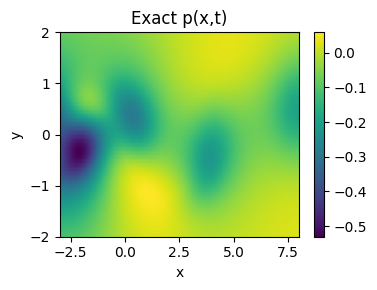

In [12]:
plt.figure(figsize=(4,3))
plt.imshow((p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

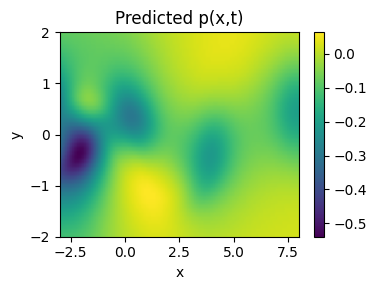

In [13]:
plt.figure(figsize=(4,3))
plt.imshow((p_pred).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

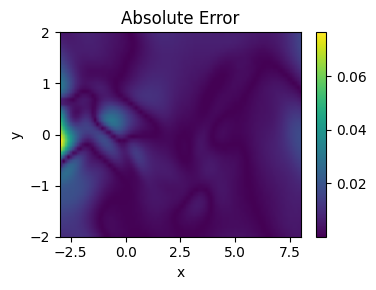

In [14]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(p_pred-p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()

In [15]:
torch.save(model.state_dict(), './ns_pinnsformer_final.pt')